# No Reference Image Quality Assessment using Laplace Variance

Assessing image quality using Laplacian variance is a widely used method in image processing, particularly for determining the sharpness or focus of an image. This approach is particularly useful because it does not require a reference image. 

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).z

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [31]:
# Import own functions
from utils import plot

## Prerequisites

Before starting this notebook there are a few steps to consider. This notebook integrates the NVIDIA CUDA Toolkit to accelerate processes defined in the OpenCV libraries. The CUDA Toolkit provides the development environment and libraries necessary to run GPU-accelerated applications, while PyTorch provides a high-level interface for GPU-accelerated machine learning tasks using CUDA.

Following these steps you will be able to run Pytorch on cuda GPU:
- See if you have an NVIDIA gpu that supports CUDA. You can check whether your supports CUDA on the [Nvidai CUDA GPUs list](https://developer.nvidia.com/cuda-gpus)
- The NVIDIA drivers allow your operating system to communicate with the GPU. Download the lates driver for your GPU from [NVIDIA GPU drivers](https://www.nvidia.com/en-us/drivers/)
- The CUDA Toolkit provides the development environment and libraries necessary to run GPU-accelerated applications. Download the [Nvidia CUDA Toolkit](https://developer.nvidia.com/cuda-12-4-0-download-archive) from the official NVIDIA website, and add CUDA binaries to your system's PATH.
- Install PyTorch with CUDA support by visiting the [PyTorch installation page](https://pytorch.org/get-started/locally/) and choosing the appropriate options.

After completing the above steps, verify CUDA is available by running the following in a Python script:

In [11]:
import torch

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())

PyTorch Version: 2.4.1+cu124
CUDA Available: True
CUDA Device Count: 1


## Theoretical background

The Laplacian is a second-order derivative operator in image processing. It measures the rate at which pixel intensity values change in both horizontal and vertical directions. This operator is particularly sensitive to rapid changes in intensity, which are often associated with edges, textures, and sharp features in an image. 

For a two-dimensional function (like an image intensity function), the Laplacian is given by:

$$ \Delta f(x, y) = \frac{\partial^2 f(x, y)}{\partial x^2} + \frac{\partial^2 f(x, y)}{\partial y^2} $$

In a **sharp image**, there are many areas of high contrast (edges, details, textures), causing the Laplacian to exhibit high variability (high variance), while in a **blurred image**, the intensity changes are more gradual, leading to smaller Laplacian values and, consequently, lower variance.

Variance quantifies the spread of Laplacian values. For a set of Laplacian values L1,L2,…,LnL1​,L2​,…,Ln​, the variance is given by:

$$ \text{Var}(L) = \frac{1}{n} \sum_{i=1}^{n} (L_i - \mu)^2 $$

Where:
- \(L_i\) represents the Laplacian value at pixel \(i\),
- \(\mu\) is the mean of the Laplacian values.

In [13]:
def laplacian_variance(image):
    # If the image is colored (3 channels), convert to grayscale
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image  # Image is already grayscale
        
    # Compute the Laplacian of the image
    laplacian = cv2.Laplacian(gray_image, cv2.CV_64F)
    
    # Return the variance of the Laplacian
    return laplacian.var()

## Analysis

Let's test the metric by loading both a colored image and a grayscale one. We should expect that both will have the same Laplacian Variance, as it will have the same gradiant map.

### Color vs Graysale

In a colored image, the Laplacian operator can be computed individually for each color channel (e.g., Red, Green, Blue). Depending on how it's implemented, you may either take the average of the Laplacians for each channel or compute it on a per-channel basis.

In a grayscale image, the Laplacian is computed on a single intensity channel, which is often a weighted combination of the red, green, and blue channels.

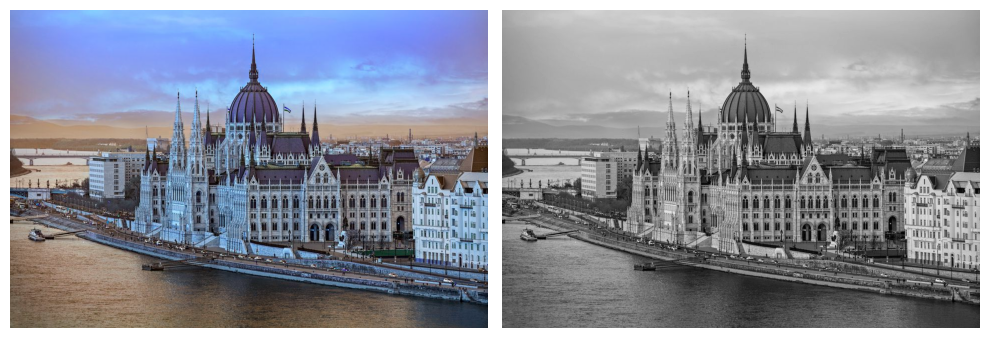

In [28]:
# Load a downloaded image.      
image_path = '/home/dave/Pictures/parlament.jpg'
color = cv2.imread(image_path)

# Convert image to grayscale
grayscale = cv2.cvtColor(color, cv2.COLOR_BGR2GRAY)

# Plot both images side by side
plot([color, grayscale], layout=(1, 2), fig_size=(10, 5))

In [25]:
# Calculate the laplacian variance of a colored image
colored_score = laplacian_variance(color)
print(f"Laplacian Variance of colored image (Image Quality Score): {colored_score}")

# Calculate the Laplacian variance of a grayscale image
grayscale_score = laplacian_variance(grayscale)
print(f"Laplacian Variance of grayscale image (Image Quality Score): {grayscale_score}")

Laplacian Variance of colored image (Image Quality Score): 2377.415675494488
Laplacian Variance of grayscale image (Image Quality Score): 2377.415675494488


When both colored and grayscale images yield the same Laplacian variance, it typically indicates that the edge structures and details are preserved through the conversion process. The effective sharpness and detail level of the images remain consistent despite the color information being lost in the grayscale version. This behavior emphasizes the importance of edge information in assessing image sharpness and quality.

This is due to the fact, that variance only reflects the deviation of a distribution, therefore is not affected by the values, but rather how do the values spread across the image. 

### Blured and Noisy images

Now let's test the validity of this metric. We naturally want the score of worse quality image to be strictly lower. The example below shows us, that adding **noise** may artificially increase sharpness (due to more random intensity changes), but the Laplacian variance may increase despite reduced perceptual quality. Hence Laplace Variance score is not reliable in case of noisy images, but in practice we can alleviate noisy by *applying a suttle Gaussian blur*.

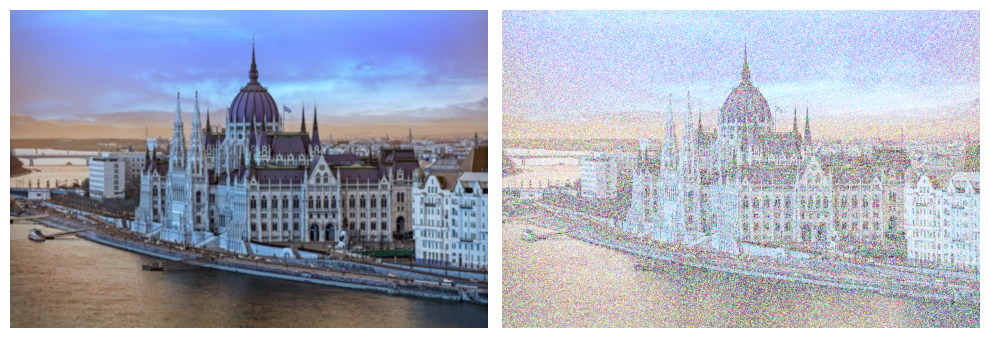

Original image score 2377.415675494488
Blured image score 88.04592609816392
Noisy image score 32422.967347821537


In [37]:
original = color

# Make an image with similar
blured_image = cv2.GaussianBlur(original, (5, 5), 0)
blured_score = laplacian_variance(blured_image)

# Calculate Laplacian Variance of noisy image
noise = np.random.normal(0, 25, original.shape).astype(np.uint8)
noisy_image = cv2.add(original, noise)
noisy_score = laplacian_variance(noisy_image)

# Show images side by side
plot([blured_image, noisy_image], layout=(1, 2), fig_size=(10, 5))

print(f"Original image score {colored_score}")
print(f"Blured image score {blured_score}")
print(f"Noisy image score {noisy_score}")


To investigate the correlation between Laplacian variance (Laplace score) and the intensity of blurriness, we can perform an experiment where you progressively increase the blur applied to an image and calculate the corresponding Laplacian variance for each blur level. This will allow you to observe how the Laplacian variance decreases as the image becomes increasingly blurred.

This might allow us to visually and quantitatively understand how Laplacian variance responds to increasing blur, confirming the reliability of Laplacian variance as a measure of image sharpness.

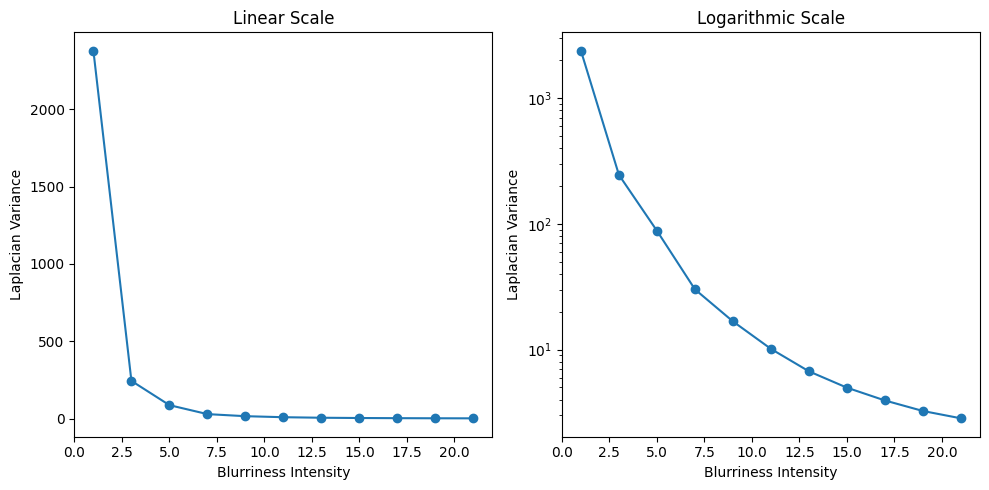

In [43]:
# Configuring parameters
max_kernel_size = 21
scores = []
kernel_sizes = list(range(1, max_kernel_size + 1, 2))

# Generate blurry images
for ksize in kernel_sizes:
    blurred_image = cv2.GaussianBlur(original, (ksize, ksize), 0)
    scores.append(laplacian_variance(blurred_image))
    
# Plot the correlation between blur intensity (kernel size) and Laplacian variance
plt.figure(figsize=(10, 5))

# Linear scale plot
plt.subplot(1, 2, 1)
plt.plot(kernel_sizes, scores, marker='o')
plt.title("Linear Scale")
plt.xlabel("Blurriness Intensity")
plt.ylabel("Laplacian Variance")

# Logarithmic scale plot
plt.subplot(1, 2, 2)
plt.semilogy(kernel_sizes, scores, marker='o')
plt.title("Logarithmic Scale")
plt.xlabel("Blurriness Intensity")
plt.ylabel("Laplacian Variance")

plt.tight_layout()
plt.show()